Image Recognition
===

This notebook will create a convolutional neural network to classify images in either the mnist or cifar-10 datasets.

In [9]:
# Tensorflow and numpy to create the neural network
import tensorflow as tf
import numpy as np

# Matplotlib to plot info to show our results
import matplotlib.pyplot as plt

# OS to load files and save checkpoints
import os

%matplotlib inline

ImportError: No module named tensorflow

Loading the data
---

This code will load the dataset that you'll use to train and test the model.

The code provided will load the mnist or cifar data from files, you'll need to add the code that processes it into a format your neural network can use.

MNIST
---

Run this cell to load mnist data.

In [3]:
# Load MNIST data from tf examples

image_height = 28
image_width = 28

color_channels = 1

model_name = "mnist"

mnist = tf.contrib.learn.datasets.load_dataset("mnist")

train_data = mnist.train.images
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)

eval_data = mnist.test.images
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)

category_names = list(map(str, range(10)))

# TODO: Process mnist data
print(train_data.shape)
train_data = np.reshape(train_data, (-1, image_height, image_width, color_channels))
print(train_data.shape)

NameError: name 'tf' is not defined

CIFAR-10
---

Run this cell to load cifar-10 data

In [ ]:
# Load cifar data from file

image_height = 32
image_width = 32

color_channels = 3

model_name = "cifar"

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

cifar_path = './cifar-10-data/'

train_data = np.array([])
train_labels = np.array([])

# Load all the data batches.
for i in range(1,6):
    data_batch = unpickle(cifar_path + 'data_batch_' + str(i))
    train_data = np.append(train_data, data_batch[b'data'])
    train_labels = np.append(train_labels, data_batch[b'labels'])


# Load the eval batch.
eval_batch = unpickle(cifar_path + 'test_batch')

eval_data = eval_batch[b'data']
eval_labels = eval_batch[b'labels'] 

# Load the english category names.
category_names_bytes = unpickle(cifar_path + 'batches.meta')[b'label_names']
category_names = list(map(lambda x: x.decode("utf-8"), category_names_bytes))

# TODO: Process Cifar data
def process_data(data):
    float_data = np.array(data, dtype=float) / 255.0
    reshaped_data = np.reshape(float_data, (-1, color_channels, image_height, image_width))
     
    transposed_data = np.transpose(reshaped_data, [0, 2, 3, 1])
    return transposed_data
    
train_data = process_data(train_data)
eval_data = process_data(eval_data)

Once the data is processed, you have a few variables for the data itself and info about its shape:

### Model Info

- **image_height, image_width** - The height and width of the processed images
- **color_channels** - the number of color channels in the image. This will be either 1 for grayscale or 3 for rgb.
- **model_name** - either "cifar" or "mnist" - if you need to handle anything differently based on the model, check this variable.
- **category_names** - strings for each category name (used to print out labels when testing results)

### Training Data

- **train_data** - the training data images
- **train_labels** - the labels for the training data - the "answer key"

### Evaluation Data

- **eval_data** - Image data for evaluation. A different set of images to test your network's effectiveness.
- **eval_labels** - the answer key for evaluation data.

Building the Neural Network Model
--

Next, you'll build a neural network with the following architecture:

- An input placeholder that takes one or more images.
- 1st Convolutional layer with 32 filters and a kernel size of 5x5 and same padding
- 1st Pooling layer with a 2x2 pool size and stride of 2
- 2nd Convolutional layer with 64 filters and a kernel size of 5x5 and same padding
- 2nd Pooling layer with a 2x2 pool size and stride of 2
- Flatten the pooling layer
- A fully connected layer with 1024 units
- A dropout layer with a rate of 0.4
- An output layer with an output size equal to the number of labels.

In [7]:
# TODO: The neural network
class ConvNet:

    def __init__(self, image_height, image_width, channels, num_classes):
        self.input_layer = tf.placeholder(dtype=tf.float32, shape=[None, image_height, image_width, channels],
                                          name="inputs")
        print(self.input_layer.shape)

        conv_layer_1 = tf.layers.conv2d(self.input_layer, filters=32, kernel_size=[5, 5], padding="same",
                                        activation=tf.nn.relu)
        print(conv_layer_1.shape)

        pooling_layer_1 = tf.layers.max_pooling2d(conv_layer_1, pool_size=[2, 2], strides=2)
        print(pooling_layer_1.shape)

        conv_layer_2 = tf.layers.conv2d(pooling_layer_1, filters=64, kernel_size=[5, 5], padding="same",
                                        activation=tf.nn.relu)
        print(conv_layer_2.shape)

        pooling_layer_2 = tf.layers.max_pooling2d(conv_layer_2, pool_size=[2, 2], strides=2)
        print(pooling_layer_2.shape)

        flattened_pooling = tf.layers.flatten(pooling_layer_2)
        dense_layer = tf.layers.dense(flattened_pooling, 1024, activation=tf.nn.relu)
        print(dense_layer.shape)
        dropout = tf.layers.dropout(dense_layer, rate=0.4, training=True)
        outputs = tf.layers.dense(dropout, num_classes)
        print(outputs.shape)

        self.choice = tf.argmax(outputs, axis=1)
        self.probability = tf.nn.softmax(outputs)

        self.labels = tf.placeholder(dtype=tf.float32, name="labels")
        self.accuracy, self.accuracy_op = tf.metrics.accuracy(self.labels, self.choice)

        one_hot_labels = tf.one_hot(indices=tf.cast(self.labels, dtype=tf.int32), depth=num_classes)
        self.loss = tf.losses.softmax_cross_entropy(onehot_labels=one_hot_labels, logits=outputs)

        optimizer = tf.train.GradientDescentOptimizer(learning_rate=1e-2)
        self.train_operation = optimizer.minimize(loss=self.loss, global_step=tf.train.get_global_step())


The Training Process
---

The cells below will set up and run the training process.

- Set up initial values for batch size, training length.
- Process data into batched datasets to feed into the network.
- Run through batches of training data, update weights, save checkpoints.

In [8]:
# TODO: initialize variables
training_steps = 20000
batch_size = 64
 
path = "./" + model_name + "-cnn/"
 
load_checkpoint = True
performance_graph = np.array([])

In [9]:
# TODO: implement the training loop
tf.reset_default_graph()
 
dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
dataset = dataset.shuffle(buffer_size=train_labels.shape[0])
dataset = dataset.batch(batch_size)
dataset = dataset.repeat()
 
dataset_iterator = dataset.make_initializable_iterator()
next_element = dataset_iterator.get_next()
 
cnn = ConvNet(image_height,image_width,color_channels,10)
 
saver = tf.train.Saver(max_to_keep=2)
 
if not os.path.exists(path):
    os.makedirs(path)
     
with tf.Session() as sess:
     
    if load_checkpoint:
        checkpoint = tf.train.get_checkpoint_state(path)
        saver.restore(sess, checkpoint.model_checkpoint_path)
    else:
        sess.run(tf.global_variables_initializer())
     
    sess.run(tf.local_variables_initializer())
    sess.run(dataset_iterator.initializer)
    for step in range(training_steps):
        current_batch = sess.run(next_element)
         
        batch_inputs = current_batch[0]
        batch_labels = current_batch[1]
         
        sess.run((cnn.train_operation, cnn.accuracy_op), feed_dict={cnn.input_layer:batch_inputs, cnn.labels:batch_labels})
        if step % 10 == 0:
            performance_graph = np.append(performance_graph, sess.run(cnn.accuracy))
         
        if step % 1000 == 0 and step > 0:
            current_acc = sess.run(cnn.accuracy)
             
            print("Accuracy at step " + str(step) + ": " + str(current_acc))
            print("Saving checkpoint")
            saver.save(sess, path + model_name, step)
         
    print("Saving final checkpoint for training session.")
    saver.save(sess, path + model_name, step)

(?, 32, 32, 3)
(?, 32, 32, 32)
(?, 16, 16, 32)
(?, 16, 16, 64)
(?, 8, 8, 64)
(?, 1024)
(?, 10)


INFO:tensorflow:Restoring parameters from ./cifar-cnn/cifar-19999


Accuracy at step 1000: 0.98541
Saving checkpoint


Accuracy at step 2000: 0.985606
Saving checkpoint


Accuracy at step 3000: 0.98589
Saving checkpoint


Accuracy at step 4000: 0.986319
Saving checkpoint


Accuracy at step 5000: 0.986537
Saving checkpoint


Accuracy at step 6000: 0.986832
Saving checkpoint


Accuracy at step 7000: 0.987109
Saving checkpoint


Accuracy at step 8000: 0.987306
Saving checkpoint


Accuracy at step 9000: 0.987495
Saving checkpoint


Accuracy at step 10000: 0.987685
Saving checkpoint


Accuracy at step 11000: 0.987869
Saving checkpoint


Accuracy at step 12000: 0.988033
Saving checkpoint


Accuracy at step 13000: 0.988285
Saving checkpoint


Accuracy at step 14000: 0.988477
Saving checkpoint


Accuracy at step 15000: 0.988656
Saving checkpoint


Accuracy at step 16000: 0.988839
Saving checkpoint


Accuracy at step 17000: 0.988978
Saving checkpoint


Accuracy at step 18000: 0.989186
Saving checkpoint


Accuracy at step 19000: 0.989322
Saving checkpoint


Saving final checkpoint for training session.


Evaluating Performance
---

These cells will evaluate the performance of your network!

Text(0,0.5,'Accuracy')

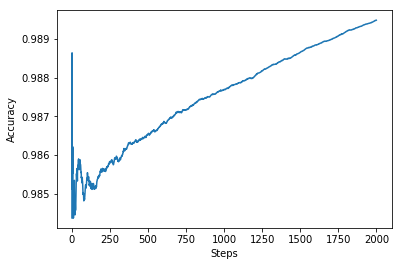

In [10]:
# TODO: Display graph of performance over time
plt.figure().set_facecolor('white')
plt.plot(performance_graph)

plt.xlabel("Steps")
plt.ylabel("Accuracy")

In [11]:
# TODO: Run through the evaluation data set, check accuracy of model
with tf.Session() as sess:
    checkpoint = tf.train.get_checkpoint_state(path)
    saver.restore(sess,checkpoint.model_checkpoint_path)
     
    sess.run(tf.local_variables_initializer())
     
    for image, label in zip(eval_data, eval_labels):
        sess.run(cnn.accuracy_op, feed_dict={cnn.input_layer:[image], cnn.labels:label})
     
    print(sess.run(cnn.accuracy))

INFO:tensorflow:Restoring parameters from ./cifar-cnn/cifar-19999


0.7057


INFO:tensorflow:Restoring parameters from ./cifar-cnn/cifar-19999


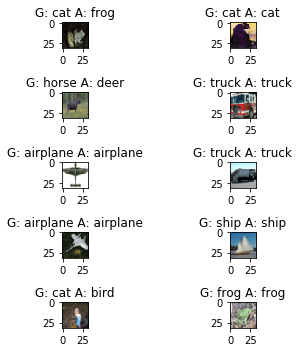

In [23]:
# TODO: Get a random set of images and make guesses for each

with tf.Session() as sess:
    checkpoint = tf.train.get_checkpoint_state(path)
    saver.restore(sess,checkpoint.model_checkpoint_path)
     
    indexes = np.random.choice(len(eval_data), 10, replace=False)
     
    rows = 5
    cols = 2
     
    fig, axes = plt.subplots(rows, cols, figsize=(5,5))
    fig.patch.set_facecolor('white')
    image_count = 0
     
    for idx in indexes:
        image_count += 1
        sub = plt.subplot(rows,cols,image_count)
        img = eval_data[idx]
        if model_name == "mnist":
            img = img.reshape(28, 28)
        plt.imshow(img)
        guess = sess.run(cnn.choice, feed_dict={cnn.input_layer:[eval_data[idx]]})
        if model_name == "mnist":
            guess_name = str(guess[0])
            actual_name = str(eval_labels[idx])
        else:
            guess_name = category_names[guess[0]]
            actual_name = category_names[eval_labels[idx]]
        sub.set_title("G: " + guess_name + " A: " + actual_name)
    plt.tight_layout()
     